# Multiclass classification of ovarian follicles

In [5]:

import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


In [3]:
BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224

IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

this_folder = os.path.abspath("")
DATA_FOLDER = os.path.join(this_folder, "data", "scenario1", "split")
MODELS_FOLDER = os.path.join(this_folder, "models")
os.listdir(DATA_FOLDER)

['val', 'train', 'test']

## Loading datasets
Let's load datasets from train, val and test directories.

In [6]:
# Train dataset
train_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'train'),
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)
class_names = train_dataset.class_names
print(class_names)

Found 569 files belonging to 5 classes.
['0_Negative', '1_Primordial', '2_Primary', '3_Secondary', '4_Tertiary']


In [7]:
# Val dataset
val_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'val'),
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 120 files belonging to 5 classes.


In [8]:
# Test dataset
test_dataset = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'test'),
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 78 files belonging to 5 classes.


## Base model
We take a pretrained model without the top and freeze its weights.

In [19]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Preprocess, global_average and prediction layers
Let's create some layers that we will add to our base model.

In [14]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

## Building of the model
We will only train the weights corresponding to the last fully connected layer.

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405  

## Compile model

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

## Fit model

In [18]:
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset)

Epoch 1/30


2021-10-20 11:43:41.008528: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


57/57 [==============================] - 10s 137ms/step - loss: 1.9777 - sparse_categorical_accuracy: 0.2162 - val_loss: 1.3939 - val_sparse_categorical_accuracy: 0.3083
Epoch 2/30
57/57 [==============================] - 8s 127ms/step - loss: 1.3701 - sparse_categorical_accuracy: 0.4130 - val_loss: 1.1283 - val_sparse_categorical_accuracy: 0.4583
Epoch 3/30
57/57 [==============================] - 8s 133ms/step - loss: 1.1345 - sparse_categorical_accuracy: 0.4974 - val_loss: 0.9435 - val_sparse_categorical_accuracy: 0.5667
Epoch 4/30
57/57 [==============================] - 11s 186ms/step - loss: 0.9694 - sparse_categorical_accuracy: 0.6221 - val_loss: 0.8271 - val_sparse_categorical_accuracy: 0.6583
Epoch 5/30
57/57 [==============================] - 9s 150ms/step - loss: 0.8379 - sparse_categorical_accuracy: 0.6854 - val_loss: 0.7480 - val_sparse_categorical_accuracy: 0.6667
Epoch 6/30
57/57 [==============================] - 9s 148ms/step - loss: 0.7406 - sparse_categorical_accurac

## Accuracy and loss plots

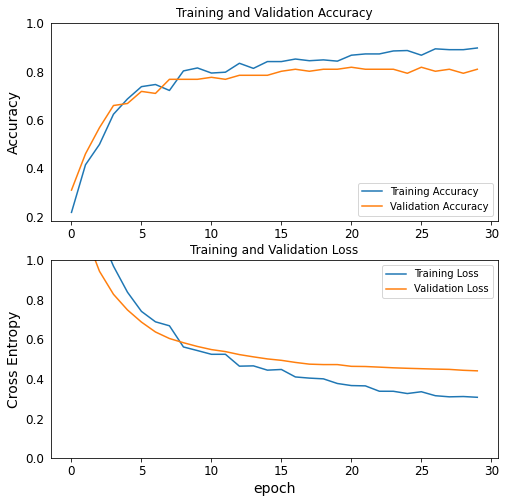

In [20]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = True
plt.rcParams['ytick.labelsize'] = True
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [8, 8]
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model evaluation on test dataset

In [21]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

8/8 [==============================] - 1s 92ms/step - loss: 0.4357 - sparse_categorical_accuracy: 0.8077
Test accuracy : 0.807692289352417


## Predictions on one batch of images

In [22]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions, axis=1)
print('predictions:', predictions)
print('truth:      ', label_batch)

predictions: [2 2 1 0 3 3 2 3 3 4]
truth:       [1 2 1 0 3 3 2 3 3 4]


## Confusion matrix

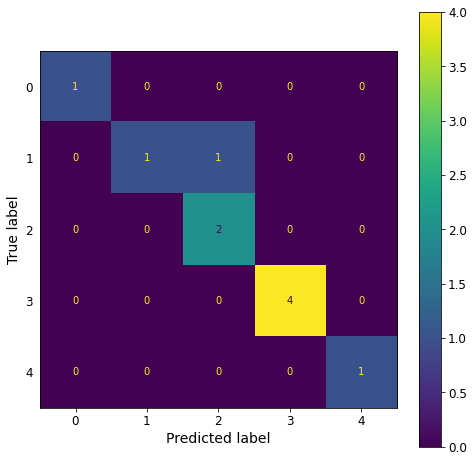

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(label_batch, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

## Classification report for one batch

In [26]:
from sklearn.metrics import classification_report

print(classification_report(label_batch, predictions, target_names=["Negative", "Primordial", "Primary", "Secondary", "Tertiary"]))

              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
  Primordial       1.00      0.50      0.67         2
     Primary       0.67      1.00      0.80         2
   Secondary       1.00      1.00      1.00         4
    Tertiary       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.93      0.90      0.89        10
weighted avg       0.93      0.90      0.89        10



## Visualization of predictions

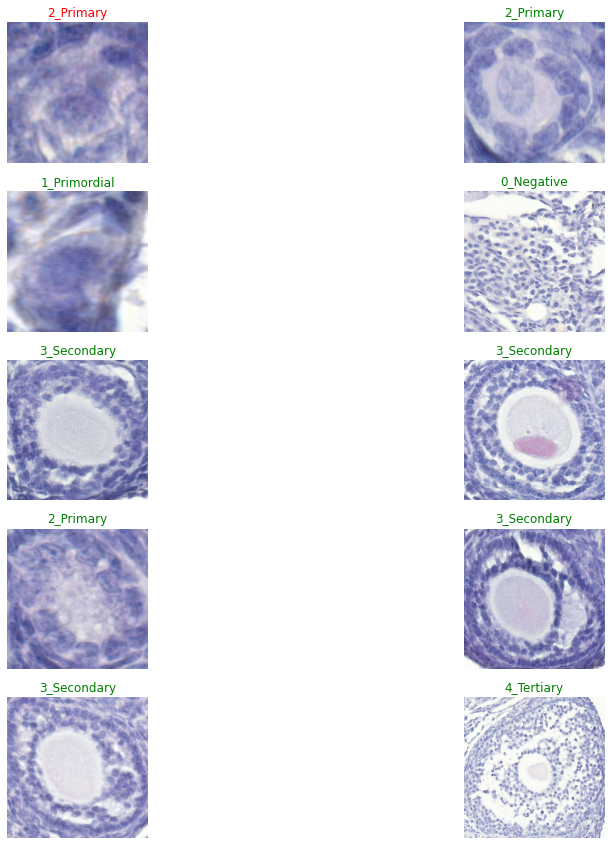

In [27]:
plt.figure(figsize=(15, 15))
for i in range(10):
  ax = plt.subplot(5, 2, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  if predictions[i] != label_batch[i]:
    color = 'red'
  else:
    color = 'green'
  plt.title(class_names[predictions[i]], color=color)
  plt.axis("off")

## Predict on the whole test dataset

In [28]:
test_dataset_nobatch = image_dataset_from_directory(
    os.path.join(DATA_FOLDER, 'test'),
    batch_size=78,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
)

Found 78 files belonging to 5 classes.


In [29]:
preds = []
labels = []
for image, label in test_dataset_nobatch.as_numpy_iterator():
    pred = model.predict(image)
    pred = np.argmax(pred, axis=1)
    preds.append(pred)
    labels.append(label)
print(preds)
print(labels)

[array([1, 1, 3, 0, 4, 2, 1, 4, 2, 2, 0, 0, 0, 0, 3, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 4, 3, 0, 0, 3, 0, 1, 2, 1, 1, 0, 0, 0, 0, 2, 1,
       4, 0, 3, 3, 0, 0, 3, 0, 2, 2, 0, 4, 0, 0, 1, 2, 2, 0, 1, 4, 1, 0,
       2, 3, 4, 0, 3, 2, 0, 0, 2, 0, 4, 1])]
[array([1, 1, 3, 0, 0, 2, 1, 3, 0, 2, 0, 0, 0, 3, 4, 0, 0, 0, 3, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 4, 3, 0, 0, 3, 0, 1, 2, 1, 0, 0, 0, 0, 0, 3, 1,
       3, 0, 3, 0, 0, 0, 3, 0, 2, 1, 0, 4, 0, 1, 1, 2, 2, 0, 1, 4, 0, 0,
       2, 3, 4, 0, 3, 2, 0, 0, 2, 0, 4, 1], dtype=int32)]


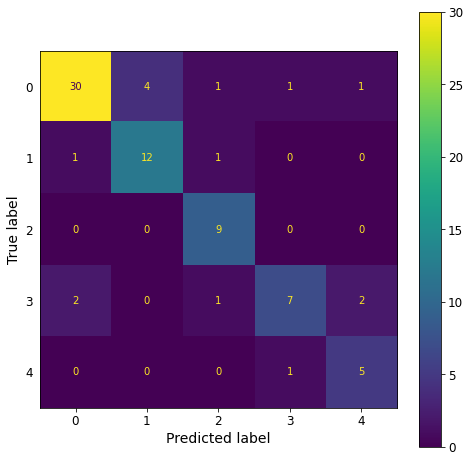

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(labels[0], preds[0])
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot()
plt.show()

## Classification report on entire test set predictions

In [31]:
from sklearn.metrics import classification_report

print(classification_report(labels[0], preds[0], target_names=["Negative", "Primordial", "Primary", "Secondary", "Tertiary"]))

              precision    recall  f1-score   support

    Negative       0.91      0.81      0.86        37
  Primordial       0.75      0.86      0.80        14
     Primary       0.75      1.00      0.86         9
   Secondary       0.78      0.58      0.67        12
    Tertiary       0.62      0.83      0.71         6

    accuracy                           0.81        78
   macro avg       0.76      0.82      0.78        78
weighted avg       0.82      0.81      0.81        78



## Prediction on cropped images from an organic cut

In [32]:
def predict_image(image, model):
    image = image.resize((224,224))
    image = np.array(image)
    image = tf.reshape(image, (1,224,224,3))
    pred = model.predict(image)
    return np.argmax(pred), np.max(pred)


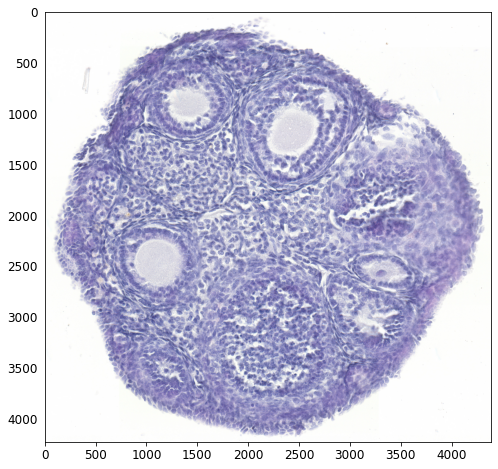

In [33]:
cut = Image.open('data/D-1M01-2.jpg')
plt.imshow(cut)

(3, 0.9366395)

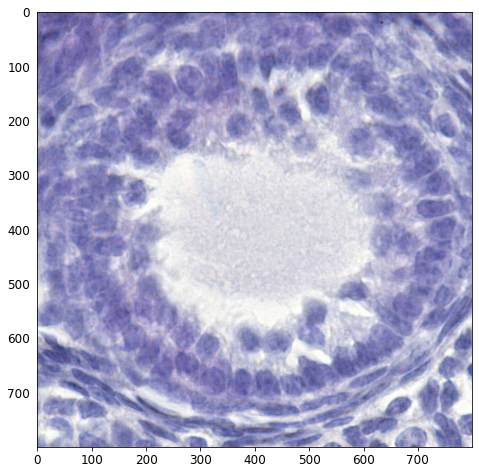

In [34]:
im1 = cut.crop((1000,500,1800,1300))
plt.imshow(im1)
predict_image(im1, model)

(0, 0.9740249)

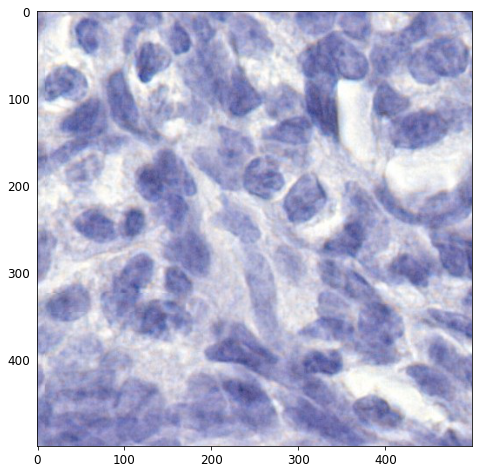

In [35]:
im2 = cut.crop((2000,2000,2500,2500))
plt.imshow(im2)
predict_image(im2, model)

(2, 0.6199514)

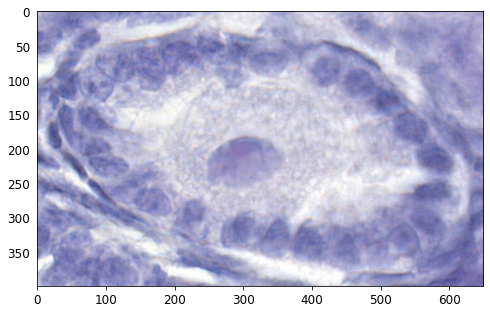

In [36]:
im3 = cut.crop((3000,2350,3650,2750))
plt.imshow(im3)
predict_image(im3, model)

(0, 0.9405716)

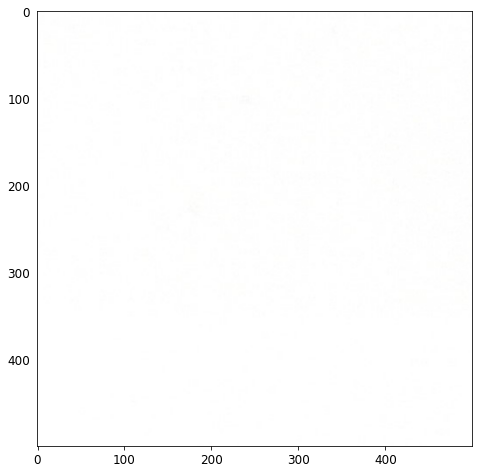

In [37]:
im4 = cut.crop((0,0,500,500))
plt.imshow(im4)
predict_image(im4, model)

## Save model

In [ ]:
# model.save(os.path.join(MODELS_FOLDER, "classifier"))

## Load saved model

In [ ]:
model_loaded = tf.keras.models.load_model(os.path.join(MODELS_FOLDER, "classifier"))
model_loaded